In [ ]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

In [ ]:
@dataclass
class Config:
    nx: int = 800
    ny: int = 400
    steps: int = 150000
    output_stride: int = 5000
    molecular_weights: tuple[float, float, float] = (30, 30)
    molecular_weights: tuple[float, float, float] = (15, 15)
    pressure_frac: tuple[float, float, float] = (0.01, 0.99)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 2

In [ ]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float64)
    mid = nx // 2
    pressure = xp.array(config.pressure_frac, dtype=xp.float64) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    y = xp.arange(ny)
    kd = 1/absorption_coefficient
    vertical_linear_profile = (kd * y +1)/(kd*ny +1)
    if ini_slope == True:
        rho_s[0] *= vertical_linear_profile[None, :]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [ ]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    extra_thickness = []
    #error_history = []

    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)

            thickness = calculate_boundary_concentration(f)
            extra_thickness.append(to_numpy(thickness))
            #plot_vertical_concentration(f)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream_BC_top_buttom, step,
                     non_absorb_mask, bc_top, bc_bottom)
        #error = to_numpy(xp.mean(abs(f-f_old)))
        #error_history.append(error)

    print(f"Saved frames to {out_dir}")

    return f, extra_thickness

In [ ]:
def calculate_boundary_concentration(f):

    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    concentration_profile = rho_s[0, :, 0]
    base_concentration = xp.min(concentration_profile)
    extra_thickness = concentration_profile - base_concentration #+ 1e-4

    normalized_extra_thickness = to_numpy(extra_thickness/base_concentration)
    '''
    plt.scatter(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], extra_thickness[to_numpy(non_absorb_mask) == 0], s = 1)
    '''

    return normalized_extra_thickness

In [ ]:
def plot_vertical_concentration(f):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    concentration_vertical = to_numpy(rho_s[0, 50, :])

    plt.plot(np.arange(200), concentration_vertical)
    plt.show()

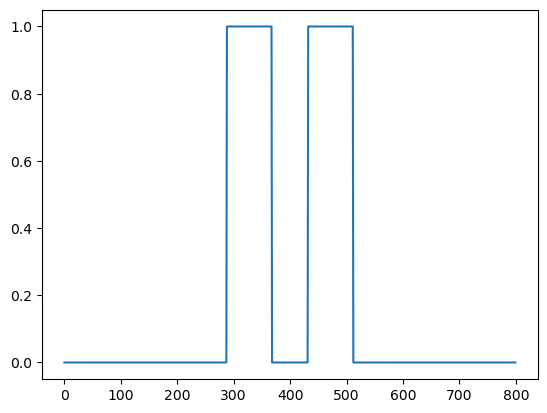

In [9]:
absorption_coefficient = 50

non_absorb_mask = xp.zeros(Config.nx, dtype=bool)
gap = 64
width = 80
non_absorb_mask[Config.nx//2 - gap//2 - width: Config.nx//2- gap//2] = True
non_absorb_mask[Config.nx//2 + gap//2 : Config.nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

#bottom boundary
b1 = xp.array([absorption_coefficient, 0, 0]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0, 89.1])/2 # stable concentration
reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

bc_bottom = (b1, b2, b3, reflection_boundary)

# top boundary
b1 = xp.array([0, 0])
b2 = xp.array([1, 1])
b3 = xp.array([0.9, 89.1])/2
reflection_boundary = np.array([0, 0, 0])

bc_top = (b1, b2, b3, reflection_boundary)


In [ ]:
#%prun -D mslbm.pstat f = main()
f, extra_thickness = main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True)

In [ ]:
extra_thickness = np.array(extra_thickness)
print(extra_thickness.shape)
for i in range(extra_thickness.shape[0]):
    plt.plot(extra_thickness[i], label=f'Step {i*Config.output_stride}')

In [ ]:
plt.plot(error_history)

In [ ]:
thickness_profile = calculate_boundary_concentration(f)
plt.plot(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], thickness_profile[to_numpy(non_absorb_mask) == 0])

In [ ]:
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
concentration_vertical = to_numpy(rho_s[0, 0, :])
fit_steps = 5
slope, b = np.polyfit(np.arange(fit_steps), concentration_vertical[:fit_steps], 1)
measured_absorption = slope/concentration_vertical[0]

plt.plot(concentration_vertical)

In [11]:
from joblib import Parallel, delayed

def _single_run(absorption_rate):

    non_absorb_mask = xp.zeros(Config.nx, dtype=bool)
    gap = 64
    width = 80
    non_absorb_mask[Config.nx//2 - gap//2 - width: Config.nx//2- gap//2] = True
    non_absorb_mask[Config.nx//2 + gap//2 : Config.nx//2 + gap//2 + width] = True
    #bottom boundary
    b1 = xp.array([absorption_rate, 0, 0]) # 1 / absorption
    b2 = xp.array([1, 1])
    b3 = xp.array([0, 89.1])/2 # stable concentration
    reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

    bc_bottom = (b1, b2, b3, reflection_boundary)

    # top boundary
    b1 = xp.array([0, 0])
    b2 = xp.array([1, 1])
    b3 = xp.array([0.9, 89.1])/2
    reflection_boundary = np.array([0, 0, 0])

    bc_top = (b1, b2, b3, reflection_boundary)
    f, extra_thickness = main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True)

    return f, extra_thickness

def parameter_sweep_parallel(num, n_jobs=2, backend="loky"):

    absorption_rates = np.linspace(5, 150, num = num, endpoint = True)
    print(f"absorption rates: {absorption_rates}")

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(absorption_rate)
        for absorption_rate in absorption_rates
    )

    f_results, thickness_history = zip(*results)
    return absorption_rates, f_results, thickness_history

In [12]:
absorption_rates, f_results, thickness_history = parameter_sweep_parallel(num = 10, n_jobs=5, backend="loky")
f_results_cpu = to_numpy(xp.array(f_results))
np.save("f_results_cpu", f_results_cpu)
np.save("thickness_history", thickness_history)

absorption rates: [  5.          21.11111111  37.22222222  53.33333333  69.44444444
  85.55555556 101.66666667 117.77777778 133.88888889 150.        ]


In [ ]:
print(np.array(thickness_history).shape)
for i in range(10):
    plt.plot(np.arange(Config.nx)[to_numpy(non_absorb_mask) == 0], np.array(thickness_history)[i, -1, :][to_numpy(non_absorb_mask) == 0])

In [ ]:
print(absorption_rates)
measured_absorption_curve = []
for i in range(10):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

    concentration_profile = to_numpy(rho_s[0, :, 0])
    base_concentration = np.min(concentration_profile)
    extra_thickness = concentration_profile - base_concentration

    normalized_extra_thickness = extra_thickness/base_concentration

    plt.plot(np.arange(len(concentration_profile))[to_numpy(non_absorb_mask) == 0], normalized_extra_thickness[to_numpy(non_absorb_mask) == 0], label=f"{absorption_rates[i]:.2g}")

plt.xlim(0, len(concentration_profile))
plt.xlim(200, 300)
plt.ylim(bottom = 1e-5)
plt.ylim(top = 2)

#plt.yscale('log')
plt.grid()
plt.legend()
plt.show()


In [ ]:
print(absorption_rates)
measured_absorption_curve = []
for i in range(10):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

    concentration_vertical = to_numpy(rho_s[0, 50, :])

    plt.plot(np.arange(200), concentration_vertical)

    fit_steps = 5
    slope, b = np.polyfit(np.arange(fit_steps), concentration_vertical[:fit_steps], 1)
    measured_absorption = slope/concentration_vertical[0]
    measured_absorption_curve.append(measured_absorption)

#plt.yscale("log")
plt.grid()
plt.show()


In [ ]:
plt.plot(measured_absorption_curve, marker = '.')
plt.plot(1/absorption_rates, marker = '*')
plt.yscale('log')

In [ ]:
i = 10
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

concentration_vertical = to_numpy(rho_s[0, 300, :])
print(np.min(concentration_vertical))
plt.plot(concentration_vertical)

In [ ]:
i = 0
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

concentration_vertical = to_numpy(rho_s[0, 300, :])
print(np.min(concentration_vertical))
plt.plot(concentration_vertical)